##Introduction

We will work on a dataset which consists of Women’s fashion online shop reviews. This dataset contains a title, a review text, and whether the review author would recommend the product. We are trying to determine whether a reviewer will recommend a product or not based on review title and review.

First, we will take a look of the train dataset. We will use this set to fit our models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv('C:/Users/alex_/Desktop/college/DS630-MachineLear/hw5_data_train.csv')
dataset.head()

,Title,Review,Recommended
0,Beautiful unique dress,Wore this to my sons wedding. found it last mi...,1
1,Had high hopes but...,"Gals, if you absolutely must have this top wai...",0
2,Buttons -buttons so cute!,I hardly believe i have not reviewed htis yet....,1
3,Love this dress,This dress is so cute and comfortable. i'm nor...,1
4,Perfect summer pants!,The linen- cotton blend breathes so well for a...,1


In [2]:
 dataset.isnull().values.any()


True

It contains missing values. We will fill them out with space character to not lose the rows.

In [3]:
dataset.isnull().sum()

Title          2852
Review          629
Recommended       0
dtype: int64

In [4]:
dataset=dataset.fillna(' ') #filling out missing values

In [5]:
 dataset.isnull().values.any()

False

Now, we can see how big is our dataset.

In [6]:
dataset.shape

(17614, 3)

In [7]:
dataset[dataset['Recommended']==1].shape

(14485, 3)

In [8]:
dataset[dataset['Recommended']==0].shape

(3129, 3)

There's a big difference between the recommended products and not recommended products. We can infere we are working with a imbalanced text classification problem.

Now, we are going to read our test dataset to make the predictions using the models we create using the training set.

In [9]:
dataset_test = pd.read_csv('C:/Users/alex_/Desktop/college/DS630-MachineLear/hw5_data_test.csv')
dataset_test.head()


,Title,Review,Recommended
0,NaN,NaN,0
1,Perfect pair!!,This pair of age stevie capris is everything t...,1
2,Talk about creature comforts!,This is a beautifully designed jacket that eve...,1
3,NaN,NaN,1
4,So comfotable,I ordered this dress in 0p since i am 5ft. it ...,1


In [10]:
dataset_test=dataset_test.fillna(' ') #filling out missing values
dataset_test.isnull().values.any()

False

In [11]:
dataset_test.shape

(5872, 3)

In [12]:
dataset_test[dataset_test['Recommended']==1].shape

(4829, 3)

In [13]:
dataset_test[dataset_test['Recommended']==0].shape

(1043, 3)

In [14]:
title_test=dataset_test.iloc[:,0].values
recom_test=dataset_test.iloc[:,2].values


Now, we are ready to make our machine learning models. We will try to experiment how different our models can be if we use different parts of our dataset. First, we will try to use only the title of our dataset and see how good can be to predict the product. Then, we will use the review body. After that, we will use both columns, title and review body (this would be the most recommended). Last one, we will concatenate the feature vectors of the title and review body and compare with the rest of the models how good (or bad) could be using this approach.

## Using title

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from joblib import Memory

location = './cachedir'
memory = Memory(location, verbose=10)

We are going to compare most frequent words in our models and the scores, to figure out which model is the best. 

In [17]:
title=dataset.iloc[:,0].values
recom=dataset.iloc[:,2].values

vect_pipe = make_pipeline(CountVectorizer(),LogisticRegressionCV(),memory=memory)
vect_pipe.fit(title,recom)
predictions = vect_pipe.predict(title_test)

print ('Accuracy score is:',vect_pipe.score(title,recom))
print ('ROC AUC score is: ', roc_auc_score(recom, vect_pipe.predict(title)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Beautiful unique dress', ..., 'Beautiful, flowy,'], dtype=object), array([1, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.1s, 0.0min
Accuracy score is: 0.9144998296809356
ROC AUC score is:  0.8040719215269143


In [18]:

vect=CountVectorizer()
title=dataset.iloc[:,0].values
recom=dataset.iloc[:,2].values
title_vect=vect.fit_transform(title)

lr=LogisticRegressionCV(cv=5).fit(title_vect,recom)
    
print ('Accuracy score is:',lr.score(title_vect,recom))
print ('ROC AUC score is: ', roc_auc_score(recom, lr.predict(title_vect)))


Accuracy score is: 0.9145566027023958
ROC AUC score is:  0.8041064399942944


If we compare both models, we are using a pipeline in the 'first model' with Logistic Regression and CountVectorizer. In the 'second model', we are using separate both functions. However, we obtained the same scores in both. This is what we want to show because these are different steps to obtain the same model. We need both steps because we need to show the most frequent words from the model and record the scores for a different dataset, in this case, test data.

In [19]:
print ('Accuracy score is:',vect_pipe.score(title_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(title_test)))

Accuracy score is: 0.8773841961852861
ROC AUC score is:  0.739406990404529


We need to make the predictions with another set of data to avoid overfitting. In this case, we see that using the training set we obtained scores of 0.91 and 0.8. However, using the test set, we obtained 0.87 and 0.74

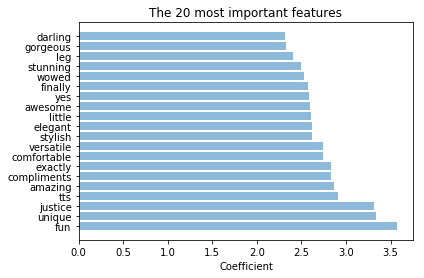

In [20]:
coef_list=np.array(lr.coef_)
coef_list=-np.sort(-lr.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr.coef_).flatten())
    feat=vect.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

Let's try to tune our model. In this case, we are going to add the parameter stop_words.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Beautiful unique dress', ..., 'Beautiful, flowy,'], dtype=object), array([1, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.1s, 0.0min


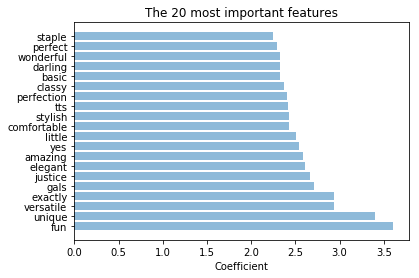

Accuracy score is: 0.8702316076294278
ROC AUC score is:  0.6970978907197587


In [21]:
vect=CountVectorizer(stop_words='english')
title_vect=vect.fit_transform(title)

lr=LogisticRegressionCV(cv=5).fit(title_vect,recom)

vect_pipe = make_pipeline(CountVectorizer(stop_words='english'),LogisticRegressionCV(),memory=memory)
vect_pipe.fit(title,recom)
predictions = vect_pipe.predict(title_test)


coef_list=np.array(lr.coef_)
coef_list=-np.sort(-lr.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr.coef_).flatten())
    feat=vect.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()


print ('Accuracy score is:',vect_pipe.score(title_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(title_test)))

We are using Accuracy and Roc Auc scores to see how good are our models. Have in mind we need roc auc score because we are working with a imbalanced dataset. In the table below, we can see the difference between the scores are not so different.

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>
    
<tr><td>Title model</td><td>0.88</td><td>0.73</td></tr>
<tr><td>Tunning Title model</td><td> 0.87 </td><td>0.70</td></tr>

## Using review body

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom and the fit is wonderfully flattering!'],
      dtype=object), 
array([1, ..., 1], dtype=int64), None)
____________

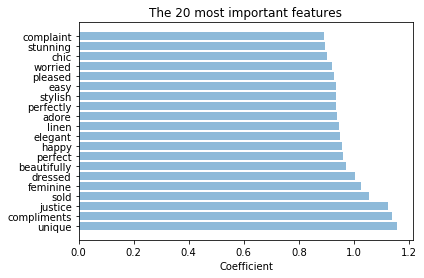

Accuracy score is: 0.8877724795640327
ROC AUC score is:  0.7784215371853536


In [22]:
rev=dataset.iloc[:,1].values
rev_test=dataset_test.iloc[:,1].values

vect_2=CountVectorizer()
rev_vect=vect_2.fit_transform(rev)

lr_2=LogisticRegressionCV(cv=5).fit(rev_vect,recom)

vect_pipe = make_pipeline(CountVectorizer(),LogisticRegressionCV(),memory=memory)
vect_pipe.fit(rev,recom)


coef_list=np.array(lr_2.coef_)
coef_list=-np.sort(-lr_2.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_2.coef_).flatten())
    feat=vect_2.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()


print ('Accuracy score is:',vect_pipe.score(rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=range(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom and the fit is wonderfully flattering!'],
      dtype=object), 
array([1, ..., 1], dtype=int64), None)
__

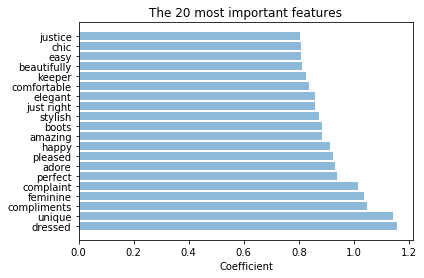

Accuracy score is: 0.8823228882833788
ROC AUC score is:  0.7574434936575862


In [23]:
rev=dataset.iloc[:,1].values
vect_2=CountVectorizer(stop_words='english',min_df=4,ngram_range=range(1,3))
rev_vect=vect_2.fit_transform(rev)

lr_2=LogisticRegressionCV(cv=5).fit(rev_vect,recom)

vect_pipe = make_pipeline(CountVectorizer(stop_words='english',min_df=4,ngram_range=range(1,3)),
                          LogisticRegressionCV(),memory=memory)
vect_pipe.fit(rev,recom)

coef_list=np.array(lr_2.coef_)
coef_list=-np.sort(-lr_2.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_2.coef_).flatten())
    feat=vect_2.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()


print ('Accuracy score is:',vect_pipe.score(rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(rev_test)))


There's  no much difference between the models' scores

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>
    
<tr><td>Review body model</td><td>0.88</td><td>0.77</td></tr>
<tr><td>Tunning review body model</td><td> 0.88 </td><td>0.76</td></tr>

## Using title and review

In [24]:
dataset["Title&Review"] = dataset["Title"].map(str) + ' ' +dataset["Review"]

tit_rev=dataset.iloc[:,3].values

dataset_test["Title&Review"] = dataset_test["Title"].map(str) + ' ' +dataset_test["Review"]

tit_rev_test=dataset_test.iloc[:,3].values

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom and the fit is wonderfully flattering!'],
      dtype=object), 
array([1, 

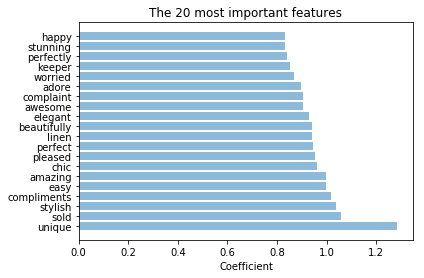

Accuracy score is: 0.8969686648501363
ROC AUC score is:  0.8013016397615318


In [25]:


vect_3=CountVectorizer()
tit_rev_vect=vect_3.fit_transform(tit_rev)

lr_3=LogisticRegressionCV(cv=5).fit(tit_rev_vect,recom)

vect_pipe = make_pipeline(CountVectorizer(),LogisticRegressionCV(),memory=memory)
vect_pipe.fit(tit_rev,recom)

coef_list=np.array(lr_3.coef_)
coef_list=-np.sort(-lr_3.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_3.coef_).flatten())
    feat=vect_3.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()


print ('Accuracy score is:',vect_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(tit_rev_test)))


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=range(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom and the fit is wonderfully flattering!'],
      dtype=object), 


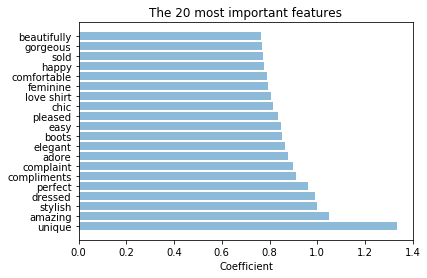

Accuracy score is: 0.8956062670299727
ROC AUC score is:  0.7876945714083199


In [26]:
vect_3=CountVectorizer(stop_words='english',min_df=4,ngram_range=range(1,3))
tit_rev_vect=vect_3.fit_transform(tit_rev)



lr_3=LogisticRegressionCV(cv=5).fit(tit_rev_vect,recom)

vect_pipe = make_pipeline(CountVectorizer(stop_words='english',min_df=4,ngram_range=range(1,3)),
                          LogisticRegressionCV(),memory=memory)
vect_pipe.fit(tit_rev,recom)

coef_list=np.array(lr_3.coef_)
coef_list=-np.sort(-lr_3.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_3.coef_).flatten())
    feat=vect_3.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()


print ('Accuracy score is:',vect_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, vect_pipe.predict(tit_rev_test)))


We see there is a slight difference between the two models.

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>
    
<tr><td>Title & Review body model</td><td>0.90</td><td>0.80</td></tr>
<tr><td>Tunning Title & review body model</td><td> 0.90 </td><td>0.79</td></tr>

Now, we are going to compare all model's scores to see which approach is the ideal to manage this dataset.

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>
     
<tr><td>Title model</td><td>0.88</td><td>0.73</td></tr>
<tr><td>Tunning Title model</td><td> 0.87 </td><td>0.70</td></tr>
<tr><td>Review body model</td><td>0.88</td><td>0.77</td></tr>
<tr><td>Tunning review body model</td><td> 0.88 </td><td>0.76</td></tr>
<tr><td>Title & Review body model</td><td>0.90</td><td>0.80</td></tr>
<tr><td>Tunning Title & review body model</td><td> 0.90 </td><td>0.79</td></tr>

We can conclude that the model using the title and review body is the best among all, so we decide to use this for the rest of the problem.

## Using Tf-dif

Next, we will introduce another method to obtain the feature matrix. We introduce Tfidf algorithm and we will compare this with the CountVectorizer we used before.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:

tfid_transf=TfidfVectorizer(norm=None)
tfid_fitted=tfid_transf.fit_transform(tit_rev)


lr_tfi=LogisticRegressionCV(cv=5).fit(tfid_fitted,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm=None),LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)


print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom an

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>

<tr><td>Title & review body model using CountVectorizer</td><td> 0.90 </td><td>0.80</td></tr>
<tr><td>Title & Review body model using tfidf</td><td>0.90</td><td>0.80</td></tr>

We see there's not much difference between both algorithms. Let's see now if the most important features of each model have changed.

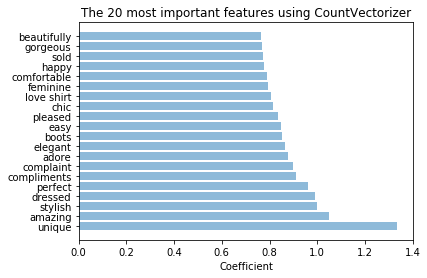

In [29]:
coef_list=np.array(lr_3.coef_)
coef_list=-np.sort(-lr_3.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_3.coef_).flatten())
    feat=vect_3.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features using CountVectorizer')
 
plt.show()

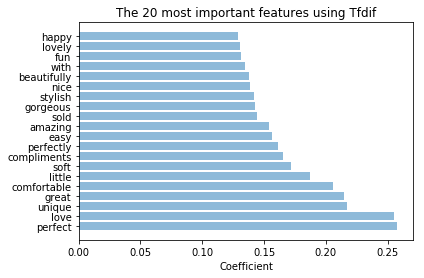

In [30]:
coef_list=np.array(lr_tfi.coef_)
coef_list=-np.sort(-lr_tfi.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi.coef_).flatten())
    feat=tfid_transf.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    #print('feature {}: {}'.format(i+1,feat))
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features using Tfdif')
 
plt.show()

The most important features for each model have changed because they are using different approaches to obtain the feature matrix, so it's understandable these words are not equal.

Now, we are going to see how different is the model if we change some parameters. In this case, we are going to change the normalization parameter.

In [31]:

tfid_transf_l2=TfidfVectorizer(norm='l2')
tfid_fitted_l2=tfid_transf_l2.fit_transform(tit_rev)


lr_tfi_l2=LogisticRegressionCV(cv=5).fit(tfid_fitted_l2,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l2'),LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)


print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom an

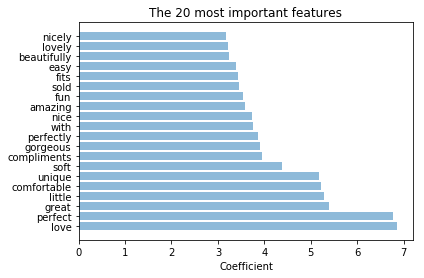

In [32]:
coef_list=np.array(lr_tfi_l2.coef_)
coef_list=-np.sort(-lr_tfi_l2.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_l2.coef_).flatten())
    feat=tfid_transf_l2.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

Here, we are changing the normalization parameter from l2 to l1

In [33]:

tfid_transf_l1=TfidfVectorizer(norm='l1')
tfid_fitted_l1=tfid_transf_l1.fit_transform(tit_rev)


lr_tfi_l1=LogisticRegressionCV(cv=5).fit(tfid_fitted_l1,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1'),LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)


print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bottom an

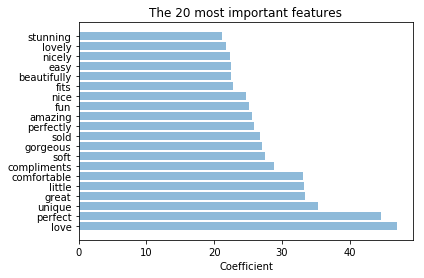

In [34]:
coef_list=np.array(lr_tfi_l1.coef_)
coef_list=-np.sort(-lr_tfi_l1.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_l1.coef_).flatten())
    feat=tfid_transf_l1.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

<table><tr><th></th><th>Accuracy</th><th>Roc auc</th></tr>

<tr><td>Tfdif approach without normalization</td><td> 0.900 </td><td>0.800</td></tr>
<tr><td>Tfdif approach with normalization l2</td><td> 0.901 </td><td>0.795</td></tr>
<tr><td>Tfdif approach with normalization l1</td><td>0.903</td><td>0.800</td></tr>

In the table above, we see that there's not big difference between the normalization parameters we used for each model. Also, if we compare the most frequent words of each model, we see that these words doesn't change at all ('perfect', 'love', 'unique', 'great' are included in every model). Now, we are going to try to change some parameters of tfdif function to see if they have an impact in the results of our models.

Here, we are going to use the parameters stop_words, which is going to exclude the most frequent words in our corpus. i.e. 'the', 'a','an', among others.

In [35]:
tfid_transf_sw=TfidfVectorizer(norm='l1', stop_words='english')
tfid_fitted_sw=tfid_transf_sw.fit_transform(tit_rev)


lr_tfi_sw=LogisticRegressionCV(cv=5).fit(tfid_fitted_sw,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1', stop_words='english'),LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)

print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bott

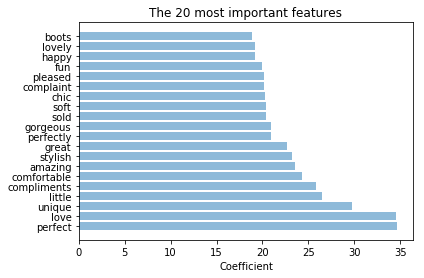

In [36]:
coef_list=np.array(lr_tfi_sw.coef_)
coef_list=-np.sort(-lr_tfi_sw.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_sw.coef_).flatten())
    feat=tfid_transf_sw.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

The graphic above with the most important features looks similar to the ones using normalization feature (it contains 'perfect', 'love', 'unique'). Also, the scores are similar to the other models. We don't see an impact using stop_words, but we need to try to use the stop_words parameters in our model as a good practice.

There's other parameters we need to know to obtain a better score in our model. These parameters are min_df and max_df.

In [37]:
tfid_transf_min=TfidfVectorizer(norm='l1', stop_words='english',min_df=4)
tfid_fitted_min=tfid_transf_min.fit_transform(tit_rev)


lr_tfi_min=LogisticRegressionCV(cv=5).fit(tfid_fitted_min,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1', stop_words='english',min_df=4),
                           LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)

print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bott

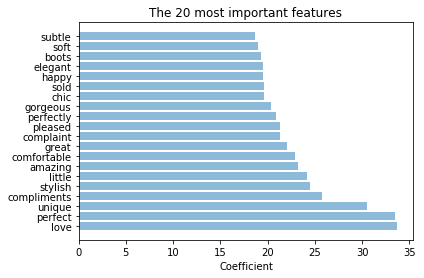

In [38]:
coef_list=np.array(lr_tfi_min.coef_)
coef_list=-np.sort(-lr_tfi_min.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_min.coef_).flatten())
    feat=tfid_transf_min.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

We see there's not much difference between the scores and the most important features of this model comparing with the previous models. However, we need to have in mind that in this case, our feature matrix was reduced of size. In conclusion, our model is running faster with this approach than the others.

In [39]:
print('Dimension of vocabulary:',tfid_fitted.shape)
print('Dimension of vocabulary using normalization type l1:',tfid_fitted_l1.shape)
print('Dimension of vocabulary using normalization type l2:',tfid_fitted_l2.shape)
print('Dimension of vocabulary using stop words:',tfid_fitted_sw.shape)
print('Dimension of vocabulary using min_df=4:',tfid_fitted_min.shape)

Dimension of vocabulary: (17614, 13010)
Dimension of vocabulary using normalization type l1: (17614, 13010)
Dimension of vocabulary using normalization type l2: (17614, 13010)
Dimension of vocabulary using stop words: (17614, 12727)
Dimension of vocabulary using min_df=4: (17614, 4706)


Above we compared the sizes of each feature matrices. In this case, we reduced the size of the matrix 35%. This method can help us with the computation time if we use a bigger dataset than this one.

## Importance of ngram

Now, we are going to introduce another parameter of tfdid function. This is ngram_range, which will allow us to use n-grams. N-grams is another way to detect language, or when syntax rules are not being followed, is using n-gram based text categorization.

In [40]:
tfid_transf_ng=TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(2,4))
tfid_fitted_ng=tfid_transf_ng.fit_transform(tit_rev)


lr_tfi_ng=LogisticRegressionCV(cv=5).fit(tfid_fitted_ng,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(2,4)),
                           LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)

print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(2, 4), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bott

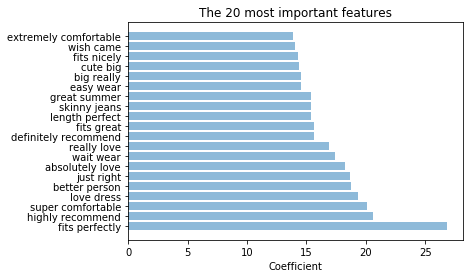

In [41]:
coef_list=np.array(lr_tfi_ng.coef_)
coef_list=-np.sort(-lr_tfi_ng.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_ng.coef_).flatten())
    feat=tfid_transf_ng.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

This is the best model until now, with good scores of Accuracy (0.99) and ROC AUC score (0.97). Watching the most frequent words of this model, we realize that every word makes sense with the prediction. Let's take a look the worst words of this model.

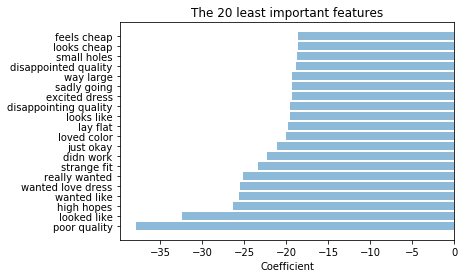

In [42]:
coef_list=np.array(lr_tfi_ng.coef_)
coef_list=np.sort(lr_tfi_ng.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_ng.coef_).flatten())
    feat=tfid_transf_ng.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 least important features')
 
plt.show()

All the words showing above in the graphic, are from the products which are not recommended for people. We can see it makes sense that people complain with the products and pointing out in the review to advice people don't buy these products.

Now, in the same way we take out certain amount of words to make the categorization, we can use certain number of characters belongs to a paragraph. This approach is named char n-grams, which will be using in the following lines.

In [43]:
tfid_transf_cg=TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(2,4),analyzer='char_wb')
tfid_fitted_cg=tfid_transf_cg.fit_transform(tit_rev)


lr_tfi_cg=LogisticRegressionCV(cv=5).fit(tfid_fitted_cg,recom)


tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(2,4),analyzer='char_wb'),
                           LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)

print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(2, 4), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum b

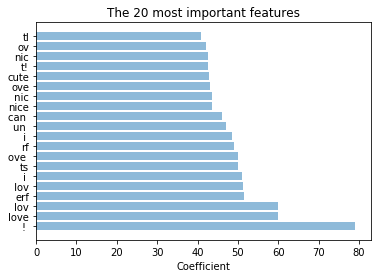

In [44]:
coef_list=np.array(lr_tfi_cg.coef_)
coef_list=-np.sort(-lr_tfi_cg.coef_)

objects=[]
performance=[]

for i in range(20):
    position = np.where(coef_list[0][i]==np.array(lr_tfi_cg.coef_).flatten())
    feat=tfid_transf_cg.get_feature_names()[position[0][0]]
    objects.append(feat)
    performance.append(coef_list[0][i])
    
    
y_pos = np.arange(len(objects))
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Coefficient')
plt.title('The 20 most important features')
 
plt.show()

After using char n-grams, we can see this is a good apporach to predict our dataset. We can see the result of the most important features, we can see the char '!' expressing admiration or astonishment for certain products, that means this would be a recommendation to buy these products. Also, we can see the characters of love on it. This means people usually use this words to recommend the products people like.

## Tunning the predictive models

Now, we are going to tune our models to obtain better accuracy and roc auc scores.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

parameters = {
    'tfidf__norm':('l1','l2',None),
    'tfidf__ngram_range': ((1, 1), (1, 2),(2,4)), 

}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('log', LogisticRegressionCV()),
    
],memory=memory)

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1)
grid_search.fit(tit_rev,recom)

print("Best score:", grid_search.best_score_)
print("Best parameters set:",grid_search.best_params_)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bott

In [46]:
tfid_transf_best=TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(1,2))
tfid_fitted_best=tfid_transf_best.fit_transform(tit_rev)


lr_tfi_best=LogisticRegressionCV(cv=5).fit(tfid_fitted_best,recom)

tfdif_pipe = make_pipeline(TfidfVectorizer(norm='l1', stop_words='english',min_df=4,ngram_range=(1,2)),
                           LogisticRegressionCV(),memory=memory)
tfdif_pipe.fit(tit_rev,recom)

print ('Accuracy score is:',tfdif_pipe.score(tit_rev_test,recom_test))
print ('ROC AUC score is: ', roc_auc_score(recom_test, tfdif_pipe.predict(tit_rev_test)))

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(1, 2), norm='l1', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 
array(['Beautiful unique dress Wore this to my sons wedding. found it last minute when i had changed my mind about another byron lars dress. i felt awesome in it and got many compliments',
       ...,
       'Beautiful, flowy, I fell in love with this shirt in the store and it has become one of my favorite items in my closet! the bright pink contrasts perfectly with the white peplum bott

There's no difference between this scores and the other we made previously. Remember that we are using an imbalanced dataset to fit our models, so it's too difficult to obtain good scores using this dataset. It would be better if we have equal amount of reviews of products that people like and dislike.